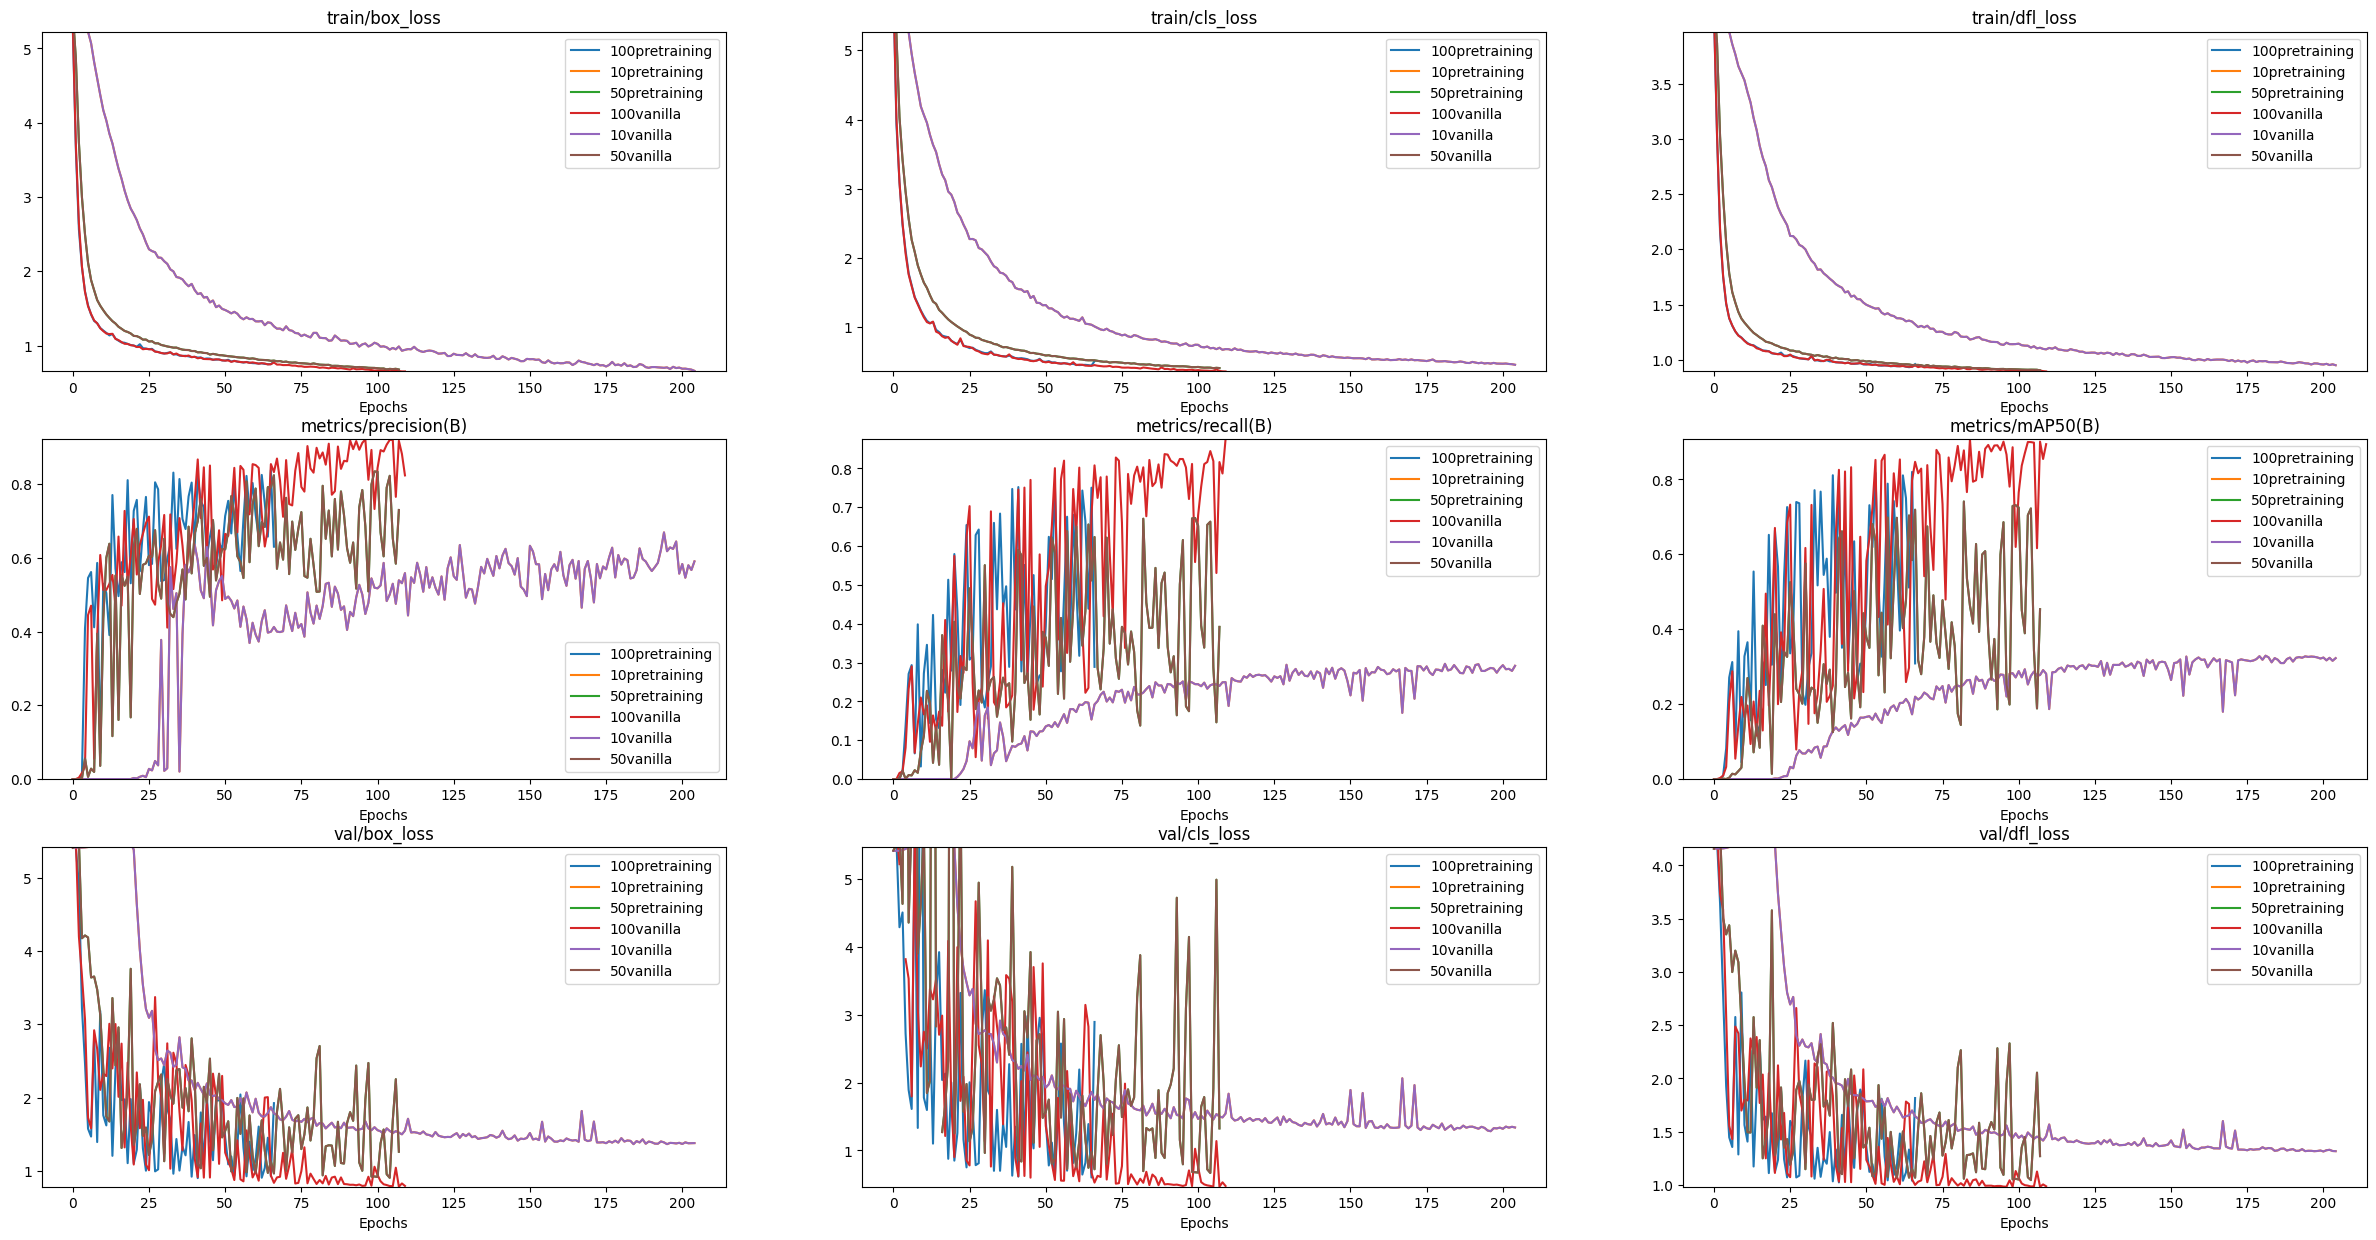

In [2]:
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


vanilla_results_dir = './Vanilla/'
pretrained_results_dir = './SSL backbone pretraining'

vanilla_dfs = dict()
pretraining_dfs = dict()

for dirname in os.listdir(vanilla_results_dir):
    vanilla_dfs[dirname] = pd.read_csv(os.path.join(vanilla_results_dir, dirname, 'results.csv'))

for dirname in os.listdir(pretrained_results_dir):
    pretraining_dfs[dirname] = pd.read_csv(os.path.join(pretrained_results_dir, dirname, 'results.csv'))


fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(30, 15))

# косяк от ultralytics, но что ж поделать
columns = ['         train/box_loss', '         train/cls_loss', '         train/dfl_loss',
           '   metrics/precision(B)', '      metrics/recall(B)', '       metrics/mAP50(B)',
           '           val/box_loss', '           val/cls_loss', '           val/dfl_loss']

for i, c in enumerate(columns):
    series = list()
    for exp_name, df in pretraining_dfs.items():
        axes[i // 3, i % 3].plot(df[c].astype(float), label=exp_name)
        series.append(df[c].astype(float).to_list())
    for exp_name, df in vanilla_dfs.items():
        axes[i // 3, i % 3].plot(df[c].astype(float), label=exp_name)
        series.append(df[c].astype(float).to_list())

    axes[i // 3, i % 3].set_title(c.strip())
    axes[i // 3, i % 3].legend()

    axes[i // 3, i % 3].set_xlabel('Epochs')

    if 'loss' in c:
        ymax = max(s[5] for s in series if not math.isinf(s[5]))
        ymin = min(min(s) for s in series)
    else:
        ymin = min(s[5] for s in series if not math.isinf(s[5]))
        ymax = max(max(s) for s in series)
    axes[i // 3, i % 3].set_ylim(ymin, ymax)

**Выводы**

Особенность задачи и данных, состоящая в следующем: <br>
1. Это задача детекции
2. Данные очень необычны: объекты мелкие, их много
3. Данных не слишком много, всего 1300 изображений на ~40 классов

делает подобное предообучение не совсем полезным, как это видно из графиков. Я немного поискал другие техники SSL-предобучения, которые бы лучше подошли для имеющейся задачи, но ничего особо дельного не нашел.

Однако, я предполагаю, что одна из нижеописанных идей может сработать:
1. Порешать задачу классификации без детекции (вырезать объекты и поклассифицировать их, тут можно взять модель даже с шеей т.к. в YOLOv8 используется SPPF, которая карту признаков любого размера преобразует в вектор фиксированной размерности)
2. Порезать картинки на сегменты поменьше и поклассифицировать пары по немного другому признаку: порешать задачу бинарной классификации на предмет принадлежности сегментов одному изображению или их соседства